In [1]:
import pyart
import fsspec
import xarray as xr
import xradar as xd
import boto3
import botocore
import numpy as np
import matplotlib.pyplot as plt
from botocore.client import Config
from datetime import datetime


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
def create_query(date, radar_site):
    """
    Creates a query for listing IDEAM radar files stored in AWS bucket
    :param date: date to be queried. e.g datetime(2021, 10, 3, 12). Datetime python object
    :param radar_site: radar site e.g. Guaviare
    :return: string with a
    """
    prefix = f'l2_data/{date:%Y}/{date:%m}/{date:%d}/{radar_site}/{radar_site[:3].upper()}{date:%y%m%d}'
    return prefix

In [3]:
str_bucket = 's3://s3-radaresideam/'

s3 = boto3.resource('s3',
                    config=Config(signature_version=botocore.UNSIGNED, 
                                  user_agent_extra='Resource'))

bucket = s3.Bucket('s3-radaresideam')

query = create_query(date=datetime(2022, 10, 6), radar_site='Guaviare')

radar_files = [f'{str_bucket}{i.key}' for i in bucket.objects.filter(Prefix=f"{query}")]

radar_files[:10]

['s3://s3-radaresideam/l2_data/2022/10/06/Guaviare/GUA221006000012.RAWHDKV',
 's3://s3-radaresideam/l2_data/2022/10/06/Guaviare/GUA221006000116.RAWHDL6',
 's3://s3-radaresideam/l2_data/2022/10/06/Guaviare/GUA221006000248.RAWHDL9',
 's3://s3-radaresideam/l2_data/2022/10/06/Guaviare/GUA221006000327.RAWHDLH',
 's3://s3-radaresideam/l2_data/2022/10/06/Guaviare/GUA221006000432.RAWHDLL',
 's3://s3-radaresideam/l2_data/2022/10/06/Guaviare/GUA221006000507.RAWHDLV',
 's3://s3-radaresideam/l2_data/2022/10/06/Guaviare/GUA221006000611.RAWHDM3',
 's3://s3-radaresideam/l2_data/2022/10/06/Guaviare/GUA221006000744.RAWHDMB',
 's3://s3-radaresideam/l2_data/2022/10/06/Guaviare/GUA221006000848.RAWHDMH',
 's3://s3-radaresideam/l2_data/2022/10/06/Guaviare/GUA221006000924.RAWHDMK']

## Using context manager and Pyart for reading radar data from guaviare radar


In [4]:
# using context manager for reading radar data from guaviare radar
of = pyart.io.prepare_for_read(radar_files[0], storage_options={'anon': True})
with of as f:
    radar = pyart.io.read(f)
    f.close()

/home/alfonso/anaconda3/envs/xrad_test/lib/python3.9/site-packages/pyart/io/sigmet.py:131: RuntimeWarning: invalid value encountered in sqrt
  sigmet_data, sigmet_metadata = sigmetfile.read_data(full_xhdr=full_xhdr)


In [5]:
radar.fields['reflectivity']

{'units': 'dBZ',
 'standard_name': 'equivalent_reflectivity_factor',
 'long_name': 'Reflectivity',
 'coordinates': 'elevation azimuth range',
 'data': masked_array(
   data=[[--, 3.5, 5.0, ..., --, --, --],
         [5.0, 6.5, 7.5, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, 1.5, --, ..., --, --, --],
         [1.5, -3.0, 3.5, ..., --, --, 7.5],
         [0.5, 0.0, 3.0, ..., --, --, --]],
   mask=[[ True, False, False, ...,  True,  True,  True],
         [False, False, False, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True, False,  True, ...,  True,  True,  True],
         [False, False, False, ...,  True,  True, False],
         [False, False, False, ...,  True,  True,  True]],
   fill_value=1e+20,
   dtype=float32),
 '_FillValue': -9999.0}

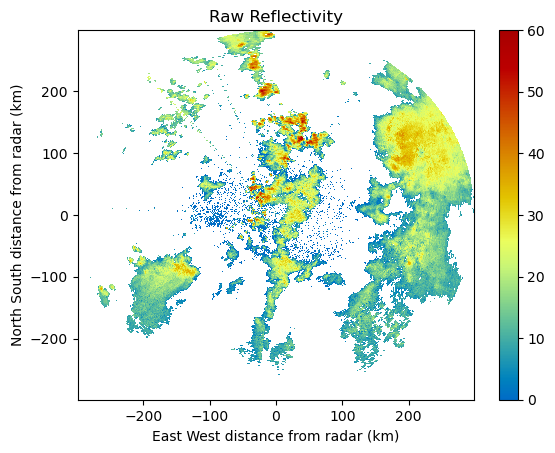

In [6]:
## Using cartesian cordinates
fig, ax = plt.subplots()
display = pyart.graph.RadarDisplay(radar)
display.plot('reflectivity', 0, ax=ax, vmin=0, vmax=60.,
             colorbar_label='', title='Raw Reflectivity')

/home/alfonso/anaconda3/envs/xrad_test/lib/python3.9/site-packages/pyart/graph/radarmapdisplay.py:279: UserWarning: No projection was defined for the axes. Overridding defined axes and using default axes with projection Lambert Conformal.
  warnings.warn(


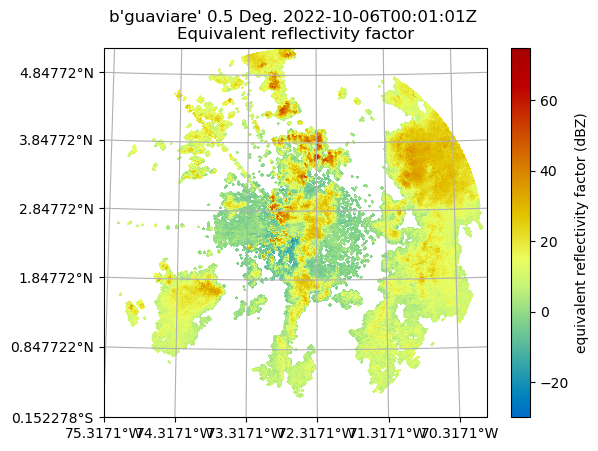

In [7]:
## Using geographic cordinates

disp1 = pyart.graph.RadarMapDisplay(radar)
disp1.plot_ppi_map('reflectivity',
                   sweep=0, 
                   min_lat=radar.gate_latitude['data'].min(),
                   max_lat=radar.gate_latitude['data'].max(),
                   min_lon=radar.gate_longitude['data'].min(),
                   max_lon=radar.gate_longitude['data'].max(),
                   lat_lines=np.arange(radar.gate_latitude['data'].min(),radar.gate_latitude['data'].max(), 1),
                   lon_lines=np.arange(radar.gate_longitude['data'].min(),radar.gate_longitude['data'].max(), 1))

In [8]:
## Using file-system reference FSSPEC and xradar for reading radar data from guaviare radar


In [9]:
file = fsspec.open_local(f'simplecache::{radar_files[0]}', s3={'anon': True}, filecache={'cache_storage': '.'})
ds = xr.open_dataset(file, engine="iris", group="sweep_0")

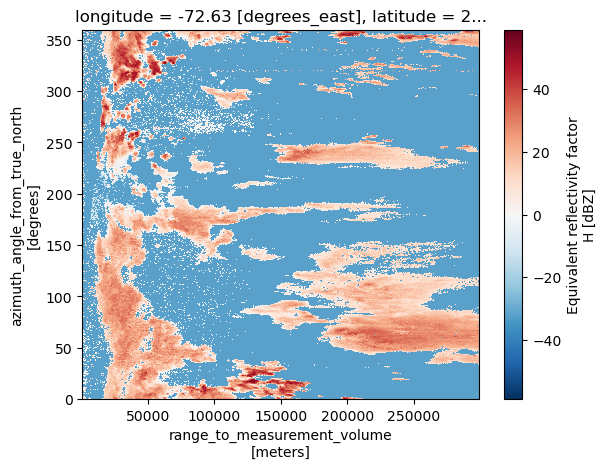

In [10]:
ds.DBZH.plot()

In [11]:
ds = xd.georeference.get_x_y_z(ds)

In [12]:
ds

<xarray.Dataset>
Dimensions:            (azimuth: 720, range: 994)
Coordinates:
  * azimuth            (azimuth) float64 0.02747 0.5191 1.024 ... 359.0 359.5
    elevation          (azimuth) float64 0.4834 0.4834 0.4834 ... 0.4834 0.4834
    time               (azimuth) datetime64[ns] ...
  * range              (range) float32 1e+03 1.3e+03 ... 2.986e+05 2.989e+05
    longitude          float64 ...
    latitude           float64 ...
    altitude           float64 ...
    x                  (azimuth, range) float64 0.4794 0.6232 ... -2.491e+03
    y                  (azimuth, range) float64 1e+03 1.3e+03 ... 2.987e+05
    z                  (azimuth, range) float64 8.496 11.07 ... 7.777e+03
Data variables: (12/17)
    DBTH               (azimuth, range) float32 ...
    DBZH               (azimuth, range) float32 ...
    VRADH              (azimuth, range) float32 ...
    WRADH              (azimuth, range) float32 ...
    ZDR                (azimuth, range) float32 ...
    KDP                (azimuth, range) float32 ...
    ...                 ...
    DB_DBZE8           (azimuth, range) int16 ...
    sweep_mode         <U20 ...
    sweep_number       int64 ...
    prt_mode           <U7 ...
    follow_mode        <U7 ...
    sweep_fixed_angle  float64 ...

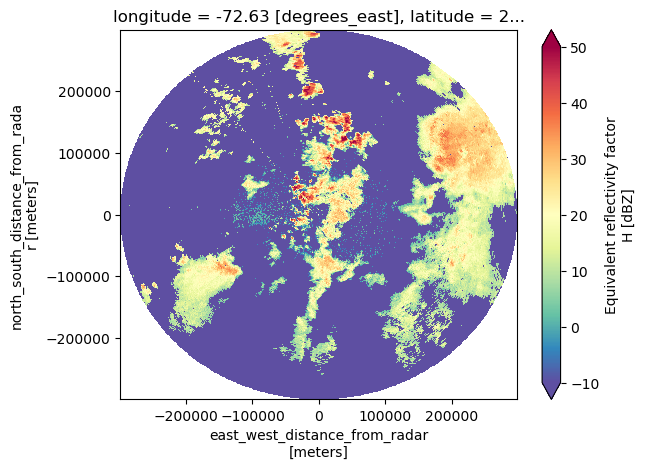

In [13]:
ds.DBZH.plot(x='x', y='y', cmap='Spectral_r', vmin=-10, vmax=50)

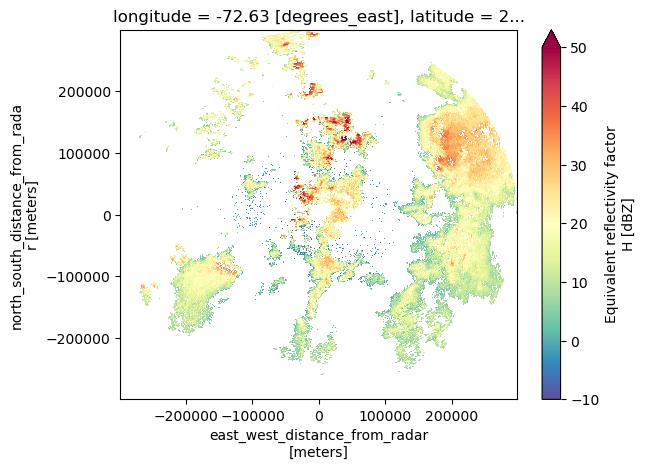

In [40]:
ds.DBZH.where(ds.DBZH > -10).where(ds.RHOHV > 0.95).plot(x='x', y='y', cmap='Spectral_r', vmin=-10, vmax=50)

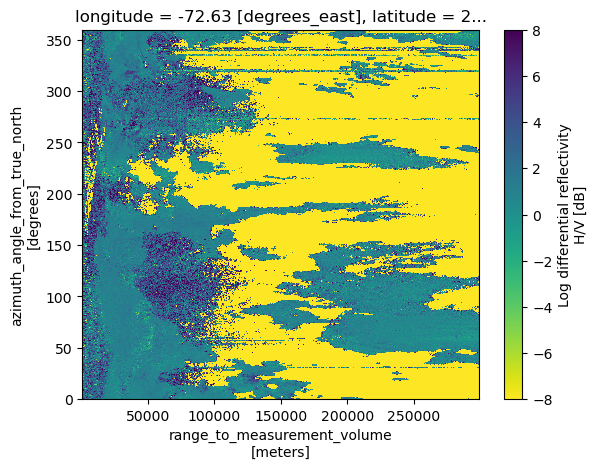

In [39]:
ds.ZDR.plot(cmap='viridis_r')

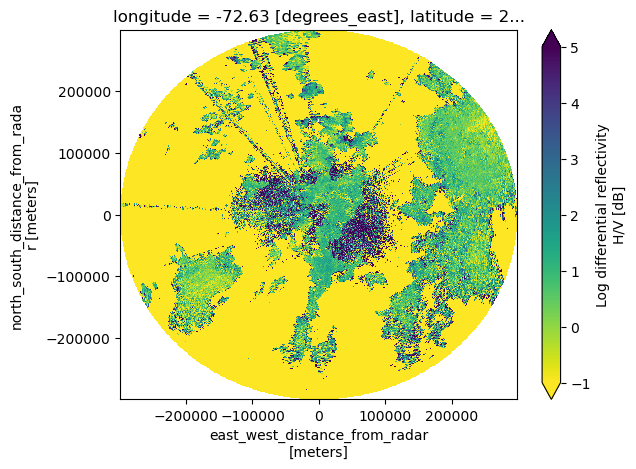

In [35]:
ds.ZDR.plot(x='x', y='y', vmin=-1, vmax=5, cmap='viridis_r')

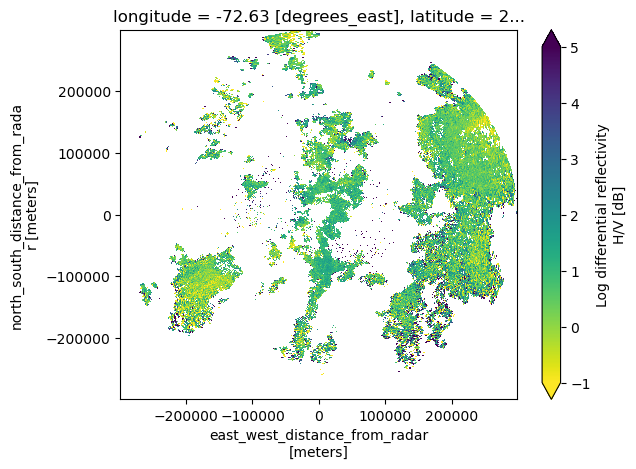

In [42]:
ds.ZDR.where(ds.DBZH > -10).where(ds.RHOHV > 0.95).plot(x='x', y='y', vmin=-1, vmax=5, cmap='viridis_r')

In [19]:
## using data tree in case the file has more than 1 elevation
file = fsspec.open_local(f'simplecache::{radar_files[0]}', s3={'anon': True}, filecache={'cache_storage': '.'})
dtree = xd.io.open_iris_datatree(file, reindex_angle=False)

In [21]:
dtree

DataTree('root', parent=None)
│   Dimensions:              ()
│   Data variables:
│       volume_number        int64 0
│       platform_type        <U5 'fixed'
│       instrument_type      <U5 'radar'
│       time_coverage_start  <U20 '2022-10-06T00:00:13Z'
│       time_coverage_end    <U20 '2022-10-06T00:01:14Z'
│       longitude            float64 -72.63
│       altitude             float64 240.0
│       latitude             float64 2.534
│   Attributes:
│       Conventions:      None
│       version:          None
│       title:            None
│       institution:      None
│       references:       None
│       source:           None
│       history:          None
│       comment:          im/exported using xradar
│       instrument_name:  None
└── DataTree('sweep_0')
        Dimensions:            (azimuth: 720, range: 994)
        Coordinates:
          * azimuth            (azimuth) float64 0.02747 0.5191 1.024 ... 359.0 359.5
            elevation          (azimuth) float32 ...
            time               (azimuth) datetime64[ns] 2022-10-06T00:01:01.330000 .....
          * range              (range) float32 1e+03 1.3e+03 ... 2.986e+05 2.989e+05
            longitude          float64 ...
            latitude           float64 ...
            altitude           float64 ...
        Data variables: (12/17)
            DBTH               (azimuth, range) float32 ...
            DBZH               (azimuth, range) float32 ...
            VRADH              (azimuth, range) float32 ...
            WRADH              (azimuth, range) float32 ...
            ZDR                (azimuth, range) float32 ...
            KDP                (azimuth, range) float32 ...
            ...                 ...
            DB_DBZE8           (azimuth, range) int16 ...
            sweep_mode         <U20 ...
            sweep_number       int64 ...
            prt_mode           <U7 ...
            follow_mode        <U7 ...
            sweep_fixed_angle  float64 ...